# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using Turi Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Turi Create

In [46]:
import turicreate

In [47]:
turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [48]:
sales = turicreate.SFrame('m_1ce96d9d245ca490.frame_idx')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [49]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [50]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in Turi Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [51]:
model_all = turicreate.linear_regression.create(sales, target='price', features=all_features,
                                                validation_set=None, 
                                                l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.011248     | 7700000.000000     | 653047.733994                   |

| 1         | 2        | 0.000002  | 3.197824     | 6962915.603493     | 426631.749026                   |

| 2         | 3        | 0.000002  | 3.398557     | 6843144.200219     | 392488.929838                   |

| 3         | 4        | 0.000002  | 3.699811     | 6831900.032123     | 385340.166783                   |

| 4         | 5        | 0.000002  | 3.907424     | 6847166.848958     | 384842.383767                   |

| 5         | 6        | 0.000002  | 4.198681     | 6869667.895833     | 385998.458623                   |

| 10        | 11       | 0.000002  | 5.499687     | 6842123.232651     | 364204.576180                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [52]:
model_all.coefficients[model_all.coefficients['value']>0]

name,index,value,stderr
(intercept),None,274873.05595049576,None
bathrooms,None,8468.531086910107,None
sqft_living,None,24.420720982445495,None
sqft_living_sqrt,None,350.0605533860576,None
grade,None,842.0680348976041,None
sqft_above,None,20.02472241709115,None


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [53]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [54]:
import numpy as np
models = []
errors = []
best_l1 = 0
best_rss = float('inf')
for l1_penalty in np.logspace(1, 7, num=13):
    model = turicreate.linear_regression.create(training, 'price', features=all_features, l1_penalty=l1_penalty,
                                        l2_penalty=0, validation_set=None, verbose=False)
    models.append(model)
    rss = model.predict(validation) - validation['price']
    rss = (rss*rss).sum()
    errors.append(rss)
    if rss<best_rss:
        best_rss = rss
        best_l1 = l1_penalty
    

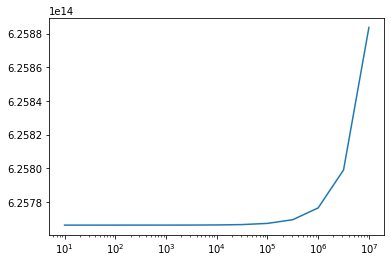

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.xscale('log')
plt.plot(np.logspace(1, 7, num=13),errors,'-')

In [55]:
best_l1

10.0

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [57]:
print(np.logspace(1, 7, num=13)[0])
print(models[0].coefficients['value'].nnz())

10.0
18


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [19]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [20]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model.coefficients['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [21]:
nonzeros = []
for l1_penalty in l1_penalty_values:
    model = turicreate.linear_regression.create(training, 'price', features=all_features, l1_penalty=l1_penalty,
                                        l2_penalty=0, validation_set=None, verbose=False)
    nonzeros.append(model.coefficients['value'].nnz())

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [23]:
i = 0
while i<len(nonzeros):
    if nonzeros[i]<=max_nonzeros:
        if i == 0:
            l1_penalty_min = l1_penalty_values[0]
        else:
            l1_penalty_min = l1_penalty_values[i-1]
        break
    i+=1
i = -1
while i>=-len(nonzeros):
    if nonzeros[i]>=max_nonzeros:
        if i == -1:
            l1_penalty_max = l1_penalty_values[-1]
        else:
            l1_penalty_max = l1_penalty_values[i+1]
        break
    i-=1
print(l1_penalty_min)
print(l1_penalty_max)

2976351441.6313133
3792690190.7322536


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [24]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [25]:
models = []
errors = []
best_l1 = 0
best_rss = float('inf')
for l1_penalty in l1_penalty_values:
    model = turicreate.linear_regression.create(training, 'price', features=all_features, l1_penalty=l1_penalty,
                                        l2_penalty=0, validation_set=None, verbose=False)
    models.append(model)
    rss = model.predict(validation) - validation['price']
    rss = (rss*rss).sum()
    errors.append(rss)
    if rss<best_rss and model.coefficients['value'].nnz()==max_nonzeros:
        best_rss = rss
        best_l1 = l1_penalty  

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [45]:
print(best_l1)
ind = np.where(l1_penalty_values==best_l1)[0][0]
models[ind].coefficients[models[ind].coefficients['value']>0]

3448968612.163437


name,index,value,stderr
(intercept),None,222253.1925443279,None
bedrooms,None,661.7227177822257,None
bathrooms,None,15873.957259267983,None
sqft_living,None,32.410221451259716,None
sqft_living_sqrt,None,690.1147733133171,None
grade,None,2899.4202697498836,None
sqft_above,None,30.011575302201155,None
